In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import anndata as ad
import requests
import urllib.request
import warnings

# Define gene sets

In [2]:
def get_allen_cortex_hippocampus_markers():
    """
    Return dictionary of known cell type markers for mouse cortex and hippocampus.
    Based on literature and Allen Brain Atlas.
    
    Returns:
    --------
    markers : dict
        Dictionary of cell type markers
    """
    markers = {
        # Excitatory neurons by region
        "Cortical_Excitatory": ["Slc17a7", "Nrgn", "Cux1", "Cux2", "Satb2", "Foxp1", "Rorb", "Deptor", "Fezf2", "Bcl6", "Tle4", "Foxp2"],
        "Hippocampal_Excitatory": ["Slc17a7", "Neurod6", "Wfs1", "Cpne5", "Gpc5", "Stxbp6", "Fibcd1", "Tshz2", "Spink8", "Prox1"],
        
        # Inhibitory neurons 
        "Cortical_Inhibitory": ["Gad1", "Gad2", "Pvalb", "Sst", "Vip", "Lamp5", "Serpinf1", "Lhx6", "Npy", "Cck"],
        "Hippocampal_Inhibitory": ["Gad1", "Gad2", "Pvalb", "Sst", "Vip", "Lamp5", "Cacna2d1", "Cxcl14", "Cck", "Calb1", "Calb2"],
        
        # Non-neuronal cells
        "Astrocytes": ["Aqp4", "Gfap", "Aldh1l1", "Slc1a3", "Slc1a2", "Gja1", "Apoe"],
        "Oligodendrocytes": ["Mbp", "Mog", "Olig1", "Olig2", "Plp1", "Cnp", "Mag", "Sox10"],
        "OPCs": ["Pdgfra", "Cspg4", "Sox10", "Olig1", "Olig2", "Pcdh15", "Lhfpl3"],
        "Microglia": ["Csf1r", "Cx3cr1", "P2ry12", "Tmem119", "Hexb", "Fcrls", "Itgam", "Aif1"],
        "Vascular": ["Cldn5", "Flt1", "Slc2a1", "Vwf", "Pecam1"],
        
        # Specialized hippocampal cell types
        "Granule_Cells": ["Dsp", "Prox1", "Lrrtm4", "Drd1a"],
        "CA1_Pyramidal": ["Wfs1", "Slc17a7", "Neurod6", "Calb1"],
        "CA2_Pyramidal": ["Amigo2", "Pcp4", "Cacng5", "Rgs14"],
        "CA3_Pyramidal": ["Bok", "Kcnq5", "Cpne4", "Grik4", "Prss12", "Spink8"]
    }
    
    return markers

In [3]:
def get_mouse_brain_markers():
    markers = {
        # Excitatory neurons
        "Excitatory_neurons": ["Slc17a7", "Neurod6", "Nrgn", "Camk2a", "Satb2"],
        
        # Inhibitory neurons
        "Inhibitory_neurons": ["Gad1", "Gad2", "Slc32a1", "Pvalb", "Sst", "Vip"],
        
        # Hippocampal cells
        "Hippocampal_CA1": ["Wfs1", "Nr3c2", "Spink8"],
        "Hippocampal_CA2": ["Amigo2", "Pcp4", "Cacng5", "Rgs14"],
        "Hippocampal_CA3": ["Bok", "Kcnq5", "Cpne4", "Grik4", "Prss12"],
        "Dentate_gyrus": ["Prox1", "Lrrtm4", "Dsp", "Ctgf", "Drd1a"],
        
        # Cortical layers
        "Layer_2_3": ["Cux1", "Cux2", "Lamp5", "Ptgs2"],
        "Layer_4": ["Rorb", "Rspo1", "Scnn1a"],
        "Layer_5": ["Bcl6", "Fezf2", "Deptor", "Ctip2", "Hsd11b1"],
        "Layer_6": ["Foxp2", "Ctgf", "Nxph2", "Tle4"],
        
        # Glial cells
        "Astrocytes": ["Aqp4", "Gfap", "Aldh1l1", "Slc1a2", "Slc1a3"],
        "Oligodendrocytes": ["Mbp", "Mog", "Plp1", "Olig1", "Sox10"],
        "OPCs": ["Pdgfra", "Cspg4", "Sox10"],
        "Microglia": ["Csf1r", "Cx3cr1", "P2ry12", "Tmem119", "Hexb"],
    }
    
    return markers

# Load data

In [4]:
# DATA dirs
base_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_"
adata_paths = {
    "Emx1_Ctrl": f"{base_path}Emx1_Ctrl_adult_0/adata_hvg.h5ad",
    "Emx1_Mut": f"{base_path}Emx1_Mut_adult_1/adata_hvg.h5ad",
    "Nestin_Ctrl": f"{base_path}Nestin_Ctrl_adult_2/adata_hvg.h5ad",
    "Nestin_Mut": f"{base_path}Nestin_Mut_adult_3/adata_hvg.h5ad"
}

# Load AnnData objects into a dictionary
adata_dict = {}
for key, path in adata_paths.items():
    print(f"Loading AnnData from {path}")
    adata_dict[key] = sc.read_h5ad(path)
    print(f"AnnData object {key} contains {adata_dict[key].n_obs} cells and {adata_dict[key].n_vars} genes")

Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_Emx1_Ctrl_adult_0/adata_hvg.h5ad
AnnData object Emx1_Ctrl contains 4707 cells and 7637 genes
Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_Emx1_Mut_adult_1/adata_hvg.h5ad
AnnData object Emx1_Mut contains 6242 cells and 6712 genes
Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_Nestin_Ctrl_adult_2/adata_hvg.h5ad
AnnData object Nestin_Ctrl contains 9512 cells and 6251 genes
Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/results/cellranger_counts_R26_Nestin_Mut_adult_3/adata_hvg.h5ad
AnnData object Nestin_Mut contains 9237 cells and 5001 genes


# Check Biomarkers

In [5]:
# Plot marker genes
markers = get_mouse_brain_markers()
sal_sample = "Emx1_Ctrl"
sel_cell_types = ["Layer_2_3", "Inhibitory_neurons"]
adata = adata_dict[sal_sample]

In [6]:
adata

AnnData object with n_obs × n_vars = 4707 × 7637
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_res0.1', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.7', 'leiden_res1.0', 'cell_type', 'cell_type_score'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden_res0.1', 'hvg', 'leiden_res0.1', 'leiden_res0.1_colors', 'leiden_res0.3', 'leiden_res0.3_colors', 'leiden_res0.5', 'leiden_res0.5_colors', 'leiden_res0.7', 'leiden_res0.7_colors', 'leiden_res1.0', 'leiden_res1.0_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'for_cell_typist'
    obsp: 'connectivities', 'distances'

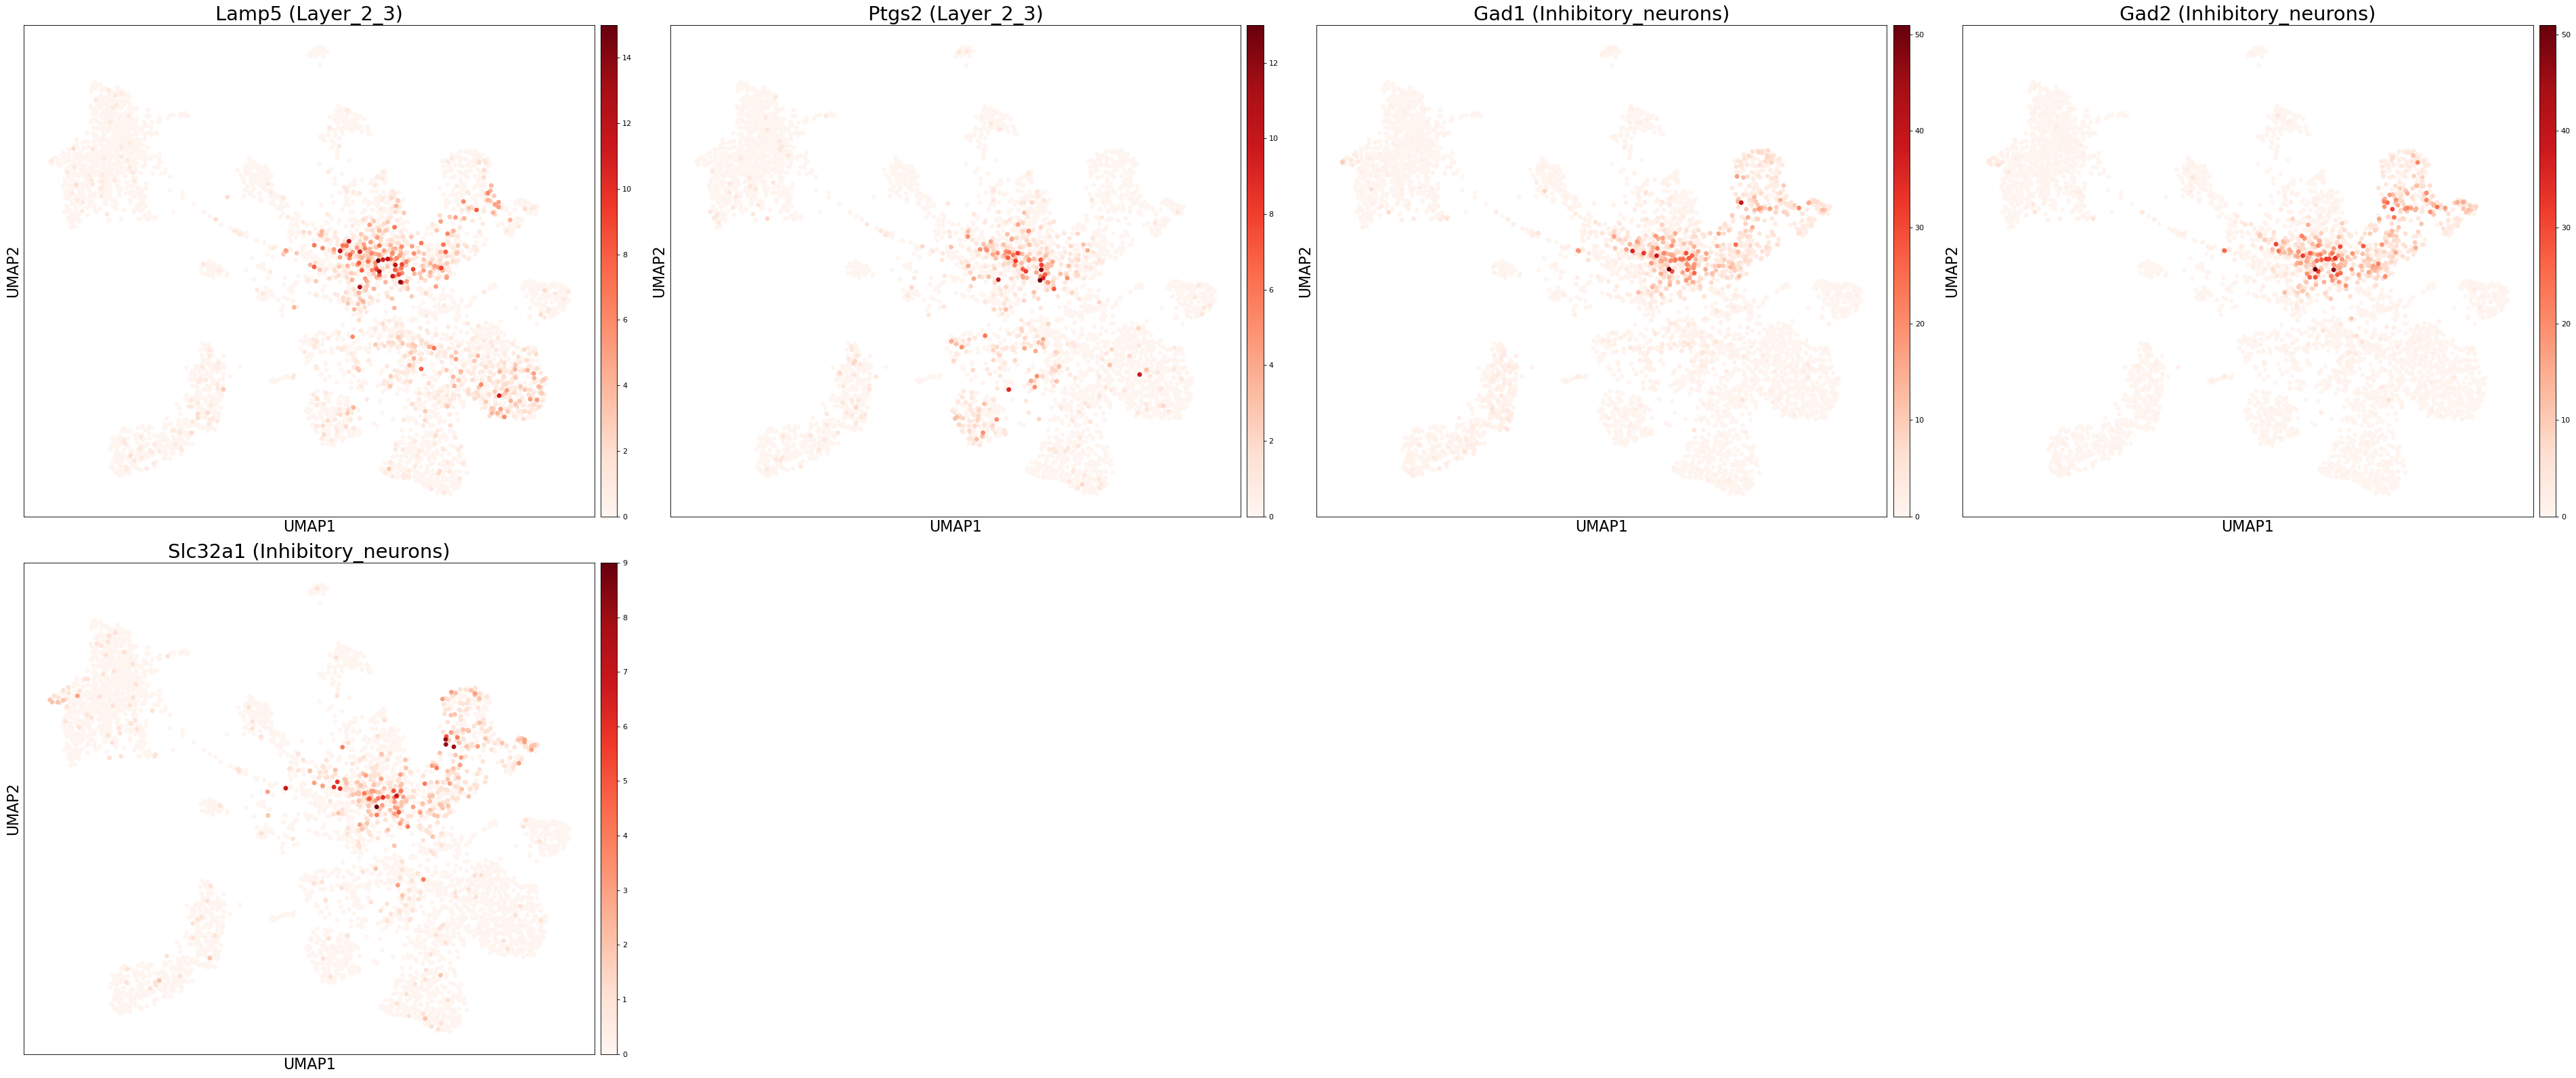

In [7]:


all_genes_to_plot = []

if markers:
    for cell_type in sel_cell_types:
        # Find genes that exist in the dataset
        valid_genes = [gene for gene in markers[cell_type] if gene in adata.var_names]
        if valid_genes:
            all_genes_to_plot.extend([(gene, cell_type) for gene in valid_genes[:3]])

    # Calculate the number of rows needed for the grid
    n_genes = len(all_genes_to_plot)
    n_cols = 4
    n_rows = (n_genes + n_cols - 1) // n_cols  # Calculate number of rows needed

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12*n_cols, 10*n_rows), dpi=80)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each marker gene in its own subplot
    for i, (gene, cell_type) in enumerate(all_genes_to_plot):
        try:
            ax = axes[i]  # Select the subplot
            sc.pl.umap(adata, color=gene, ax=ax, 
                        title=f"{gene} ({cell_type})", cmap='Reds', show=False,
                        size=150)  # Increase data point size
            ax.set_xlabel("UMAP1", fontsize=20)  # Increase axis label size
            ax.set_ylabel("UMAP2", fontsize=20)  # Increase axis label size
            ax.tick_params(axis='both', which='major', labelsize=18)  # Increase tick label size
            ax.set_title(f"{gene} ({cell_type})", fontsize=26) # Increase title size
            
        except Exception as e:
            print(f"Error plotting marker gene {gene}: {e}")

    # Remove any unused subplots
    for i in range(n_genes, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()